In [23]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
# Thêm thư mục gốc dự án vào Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Đã thêm thư mục gốc dự án vào sys.path: {project_root}")

# Import các hàm
from src import load_data, plot_target_distribution, plot_missing_values, plot_univariate_distribution, plot_correlation_heatmap
import numpy as np

# Tải & Kiểm tra Cấu trúc Dữ liệu (Load & Inspect)**

- Load file aug_train.csv và in ra 5 dòng đầu, kích thước (shape)
- Dữ liệu có bao nhiêu dòng, bao nhiêu cột?
- Các cột tên là gì? Cột nào là số (numerical), cột nào là chữ (categorical)?
- Cột nào là nhãn cần dự đoán (target)?

In [24]:
PATH_TRAIN = '../data/raw/aug_train.csv' 
data, header, field_map = load_data(PATH_TRAIN)
print(f"Kích thước dữ liệu (Số dòng, Số cột): ({data.shape[0]}, {len(header)})")
numerical_cols = []
categorical_cols = []
for col_name in header:
    col_dtype = data[field_map[col_name]].dtype
    if np.issubdtype(col_dtype, np.number):
        numerical_cols.append(col_name)
    else:
        categorical_cols.append(col_name)

print(f"Danh sách cột SỐ ({len(numerical_cols)}):")
print(numerical_cols)

print(f"Danh sách cột CHỮ/PHÂN LOẠI ({len(categorical_cols)}):")
print(categorical_cols)

target_col = 'target'
if target_col in header:
    print(f"Cột nhãn cần dự đoán (Target): '{target_col}'")
else:
    print("Cảnh báo: Không tìm thấy cột 'target' trong dữ liệu này.")

# In 5 dòng đầu tiên
print("\n--- 5 DÒNG ĐẦU TIÊN ---")
for i in range(5):
    print(f"{data[i]}")

Kích thước dữ liệu (Số dòng, Số cột): (19158, 14)
Danh sách cột SỐ (4):
['enrollee_id', 'city_development_index', 'training_hours', 'target']
Danh sách cột CHỮ/PHÂN LOẠI (10):
['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
Cột nhãn cần dự đoán (Target): 'target'

--- 5 DÒNG ĐẦU TIÊN ---
(8949, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', 36, 1.)
(29725, 'city_40', 0.776, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', 47, 0.)
(11561, 'city_21', 0.624, '', 'No relevent experience', 'Full time course', 'Graduate', 'STEM', '5', '', '', 'never', 83, 0.)
(33241, 'city_115', 0.789, '', 'No relevent experience', '', 'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never', 52, 1.)
(666, 'city_162', 0.767, 'Male', 'Has relevent experience', 'no_enrollment'

# Phân tích Biến Mục tiêu (Target Analysis)**

- Đếm số lượng và vẽ biểu đồ cột cho biến target (0 và 1).
- Tỷ lệ giữa người muốn đổi việc (1) và người không (0) là bao nhiêu?
- Có bị mất cân bằng lớp (Imbalanced Class) không? (Ví dụ: 90% lớp 0 và chỉ 10% lớp 1 là mất cân bằng nặng => Cần lưu ý khi chọn độ đo đánh giá như F1-Score thay vì Accuracy).

Tổng số mẫu: 19158
- Số người KHÔNG đổi việc (0): 14381 (75.07%)
- Số người MUỐN đổi việc (1): 4777 (24.93%)


d:\_STUDY\LTKHDL\Lab\HW02\HR-Analytics-Job-Change-of-Data-Scientists\src\visualization.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


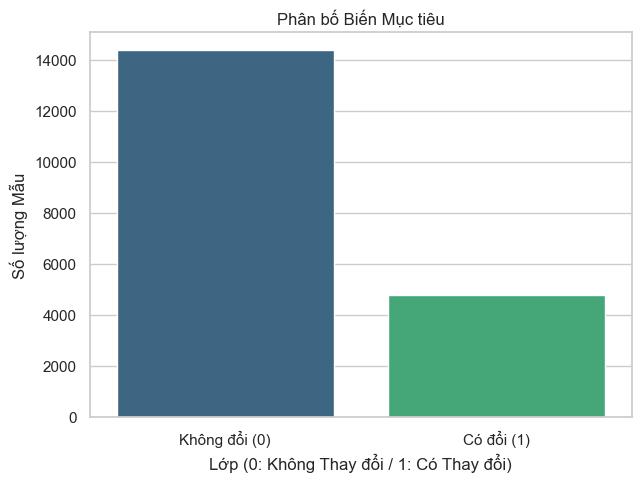

In [25]:
# Lấy cột Target
targets = data[field_map['target']]

# Tính toán tỷ lệ
count_1 = np.sum(targets == 1.0)
count_0 = np.sum(targets == 0.0)
total = len(targets)
ratio_1 = count_1 / total * 100

print(f"Tổng số mẫu: {total}")
print(f"- Số người KHÔNG đổi việc (0): {count_0} ({100 - ratio_1:.2f}%)")
print(f"- Số người MUỐN đổi việc (1): {count_1} ({ratio_1:.2f}%)")

# Vẽ biểu đồ
plot_target_distribution(targets, labels=['Không đổi (0)', 'Có đổi (1)'])

**Nhận định:**
* Dữ liệu có sự **mất cân bằng lớp (Class Imbalance)**: Lớp 0 chiếm khoảng 75%, trong khi lớp 1 chỉ chiếm 25%.

=> Khi đánh giá mô hình, không nên chỉ dựa vào độ chính xác (Accuracy). Cần quan tâm đến các chỉ số như **Precision, Recall** và **F1-Score** để đảm bảo mô hình dự đoán tốt cho lớp thiểu số (người muốn đổi việc).

Tỷ lệ giá trị thiếu theo cột:
enrollee_id: 0.00%
city: 0.00%
city_development_index: 0.00%
gender: 23.53%
relevent_experience: 0.00%
enrolled_university: 2.01%
education_level: 2.40%
major_discipline: 14.68%
experience: 0.34%
company_size: 30.99%
company_type: 32.05%
last_new_job: 2.21%
training_hours: 0.00%
target: 0.00%


d:\_STUDY\LTKHDL\Lab\HW02\HR-Analytics-Job-Change-of-Data-Scientists\src\visualization.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages, y=cols, palette='Reds_d')


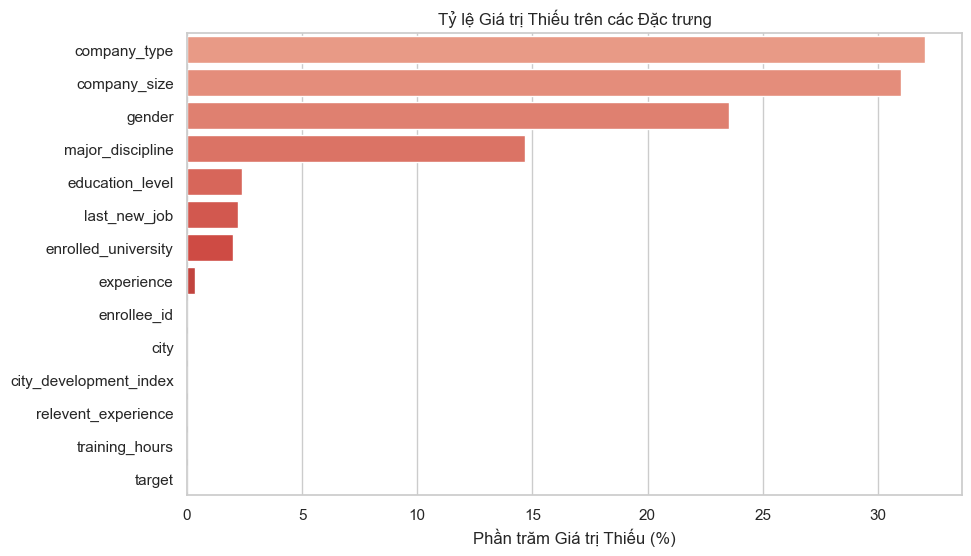

In [26]:
# Tạo dictionary missing_percentages
missing_percentages = {}

# Duyệt qua các cột (field_map)
for col_name, field_name in field_map.items():
    column = data[field_name]
    
    # Đếm giá trị thiếu (chuỗi rỗng hoặc NaN)
    if column.dtype.kind in ['U', 'S', 'O']:  # String hoặc Object
        missing_count = np.sum(column == '')
    else:  # Numeric
        missing_count = np.sum(np.isnan(column.astype(float)))
    
    # Tính phần trăm
    missing_percent = (missing_count / len(column)) * 100
    missing_percentages[col_name] = missing_percent

print("Tỷ lệ giá trị thiếu theo cột:")
for col, percent in missing_percentages.items():
    print(f"{col}: {percent:.2f}%")

plot_missing_values(missing_percentages)

**Nhận định:**
* Các cột **`company_type`** và **`company_size`** thiếu dữ liệu rất lớn (khoảng 30%). Cột `gender` thiếu khoảng 23%.
* **Giải pháp:** Trong bước tiền xử lý (Preprocessing), chúng ta sẽ điền giá trị thiếu của các cột danh mục bằng một nhãn riêng là **'Unknown'** để giữ lại thông tin về việc thiếu dữ liệu này (có thể do ứng viên thất nghiệp hoặc mới ra trường).

### Câu hỏi Nghiên cứu (Analysis & Insights)

Chúng ta sẽ tập trung phân tích 2 biến số quan trọng nhất:
1.  **`city_development_index`**: Chỉ số phát triển của thành phố.
2.  **`training_hours`**: Số giờ đào tạo đã hoàn thành.

**Câu hỏi 1:** "Nguồn ứng viên của công ty chủ yếu đến từ các khu vực như thế nào? Có phải đa số ứng viên đều đang sống ở các thành phố phát triển (chỉ số cao) không?"

--- Phân bố: City Development Index ---


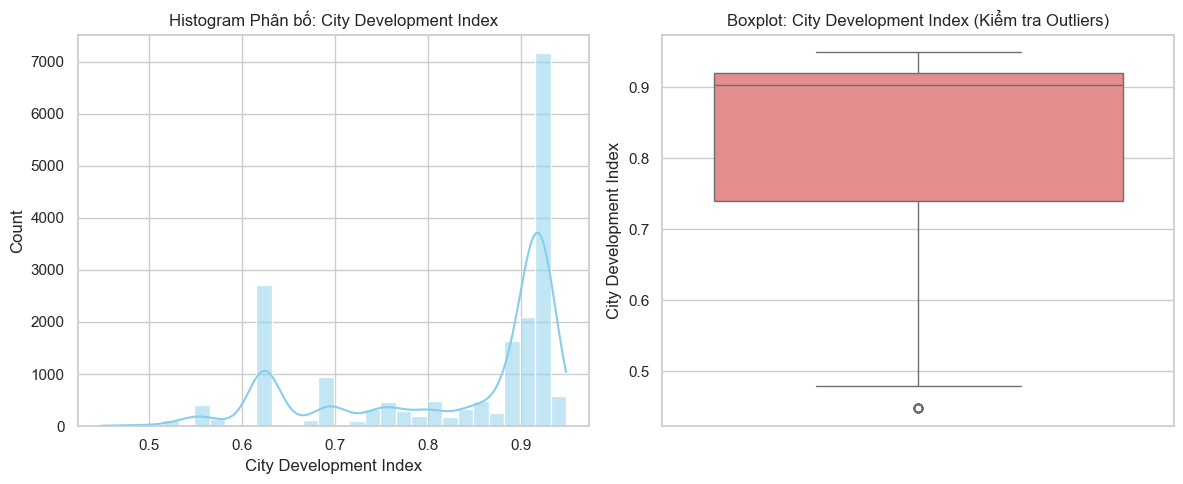

In [27]:
# --- 1. Phân tích Đơn biến (Histogram & Boxplot) ---
city_dev = data[field_map['city_development_index']]
# Lọc NaN để vẽ biểu đồ
valid_city_dev = city_dev[~np.isnan(city_dev)]

print("--- Phân bố: City Development Index ---")
plot_univariate_distribution(valid_city_dev, 'City Development Index')

**Nhận định:**

- Dữ liệu cho thấy sự phân bố không đồng đều. Có những đỉnh (peak) rất cao ở khoảng chỉ số 0.9 (thành phố rất phát triển) và một nhóm nhỏ hơn ở khoảng 0.6 (kém phát triển hơn).
- Điều này cho thấy tập dữ liệu bị phân cực. Việc ứng viên tập trung đông ở các thành phố phát triển có thể ảnh hưởng đến mô hình nếu chúng ta không xử lý tốt (ví dụ: mô hình sẽ học tốt hơn cho nhóm thành phố lớn).

**Câu hỏi 2:** "Liệu môi trường sống hiện tại có phải là động lực thúc đẩy nhân viên nghỉ việc? Người ở thành phố kém phát triển có xu hướng muốn 'nhảy việc' cao hơn không?"

C:\Users\chiph\AppData\Local\Temp\ipykernel_10136\3878976588.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targets, y=city_dev, palette='coolwarm')


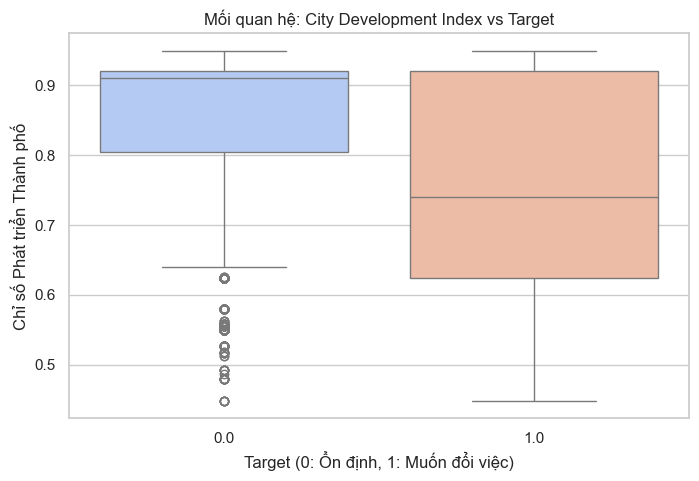

In [28]:
# Vẽ Boxplot so sánh phân bố City Index giữa 2 nhóm Target
plt.figure(figsize=(8, 5))
sns.boxplot(x=targets, y=city_dev, palette='coolwarm')
plt.title('Mối quan hệ: City Development Index vs Target')
plt.xlabel('Target (0: Ổn định, 1: Muốn đổi việc)')
plt.ylabel('Chỉ số Phát triển Thành phố')
plt.show()

**Nhận định:**

- ***Quan sát:*** Hộp màu cam (Target=1: Muốn đổi việc) có vị trí thấp hơn hẳn so với hộp màu xanh (Target=0: Ổn định). Giá trị trung vị (đường gạch ngang trong hộp) của nhóm muốn nghỉ việc thấp hơn đáng kể.
- ***Kết luận:*** Có mối liên hệ ngược chiều rõ rệt. Ứng viên sống ở các thành phố có chỉ số phát triển thấp có xu hướng muốn thay đổi công việc cao hơn.
- ***Lý do thực tế:*** Có thể do lương thấp, ít cơ hội thăng tiến hoặc chất lượng cuộc sống chưa cao tại các thành phố này khiến họ muốn tìm cơ hội mới (hiện tượng "chảy máu chất xám" về các đô thị lớn).

**Câu hỏi 3:** "Giữa 'Môi trường sống' (`City Dev Index`) và 'Đào tạo' (`Training Hours`), yếu tố nào có trọng số lớn hơn trong việc dự báo nhân viên nghỉ việc? Số giờ đào tạo nhiều có đồng nghĩa với việc nhân viên trung thành hơn không?"

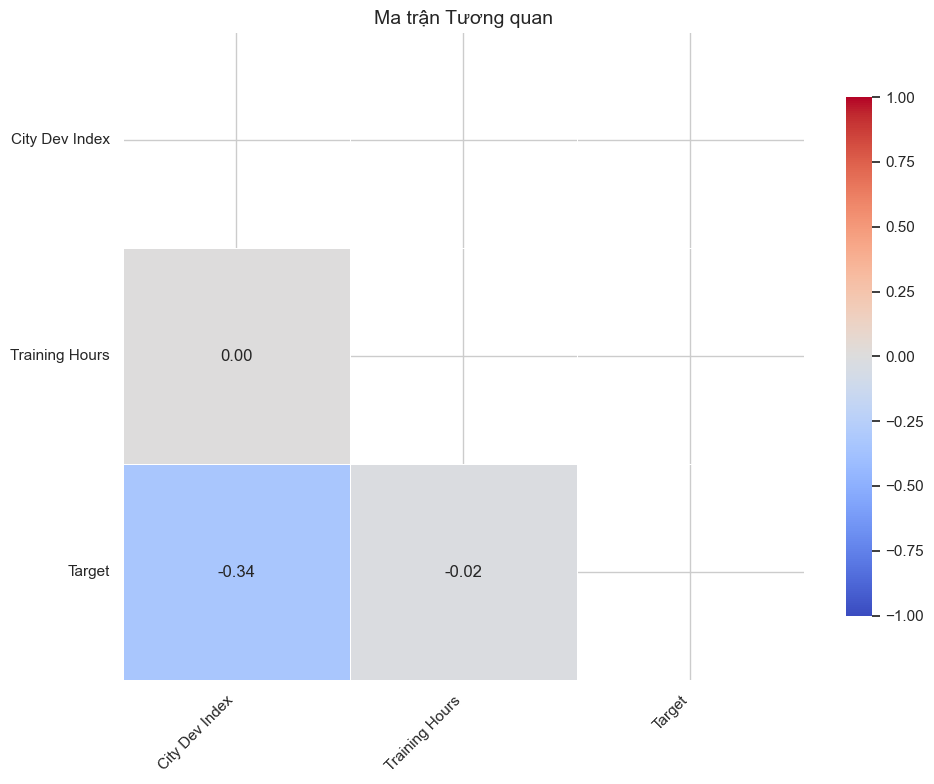

In [29]:
hours_data = data[field_map['training_hours']]

# Tạo mask để lọc các hàng có NaN trong bất kỳ cột nào
mask_valid = (~np.isnan(city_dev)) & (~np.isnan(targets))

# Gom lại thành ma trận 2D để tính tương quan
X_corr = np.column_stack([
    city_dev[mask_valid], 
    hours_data[mask_valid], 
    targets[mask_valid]
])

feature_names = ['City Dev Index', 'Training Hours', 'Target']
plot_correlation_heatmap(X_corr, feature_names=feature_names, title="Ma trận Tương quan")

**Nhận định:**

- City Development Index: Có chỉ số tương quan âm đáng kể với Target (màu xanh đậm trên biểu đồ). Điều này xác nhận lại nhận định ở Boxplot: Chỉ số thành phố càng cao, khả năng nghỉ việc càng thấp.
- Training Hours: Chỉ số tương quan với Target gần bằng 0 (màu rất nhạt).

=> Kết luận: Số giờ đào tạo không có mối quan hệ tuyến tính rõ ràng với việc nhân viên đi hay ở. Điều này gợi ý rằng việc tăng cường đào tạo chưa chắc đã là giải pháp giữ chân nhân viên hiệu quả nếu các yếu tố khác (như địa điểm làm việc) không được thỏa mãn.

## Mở rộng

Sử dụng trường `last_new_job`

**Câu hỏi 4:** Những người hay nhảy việc trong quá khứ liệu có dễ đi tiếp không?

C:\Users\chiph\AppData\Local\Temp\ipykernel_10136\2906324470.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=last_job_col, y=target_col,


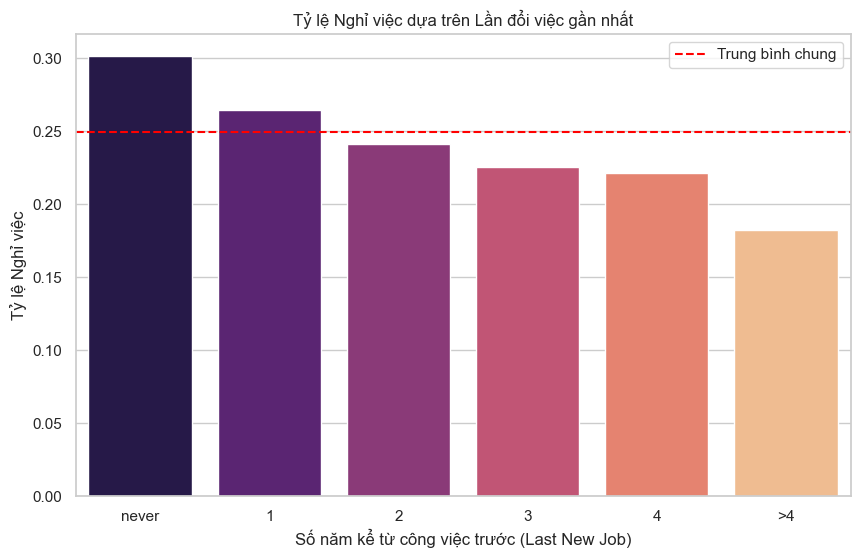

In [30]:
# Lấy dữ liệu
last_job_col = data[field_map['last_new_job']]
target_col = data[field_map['target']]

# Sắp xếp thứ tự hiển thị
job_order = ['never', '1', '2', '3', '4', '>4']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=last_job_col, y=target_col, 
            order=job_order, palette='magma', errorbar=None)

plt.title("Tỷ lệ Nghỉ việc dựa trên Lần đổi việc gần nhất")
plt.xlabel("Số năm kể từ công việc trước (Last New Job)")
plt.ylabel("Tỷ lệ Nghỉ việc")
# Vẽ đường trung bình
plt.axhline(y=np.mean(target_col.astype(float)), color='red', linestyle='--', label='Trung bình chung')
plt.legend()
plt.show()

**Nhận định:**

- Nhóm rủi ro cao nhất: `never` - Những người đang làm công việc đầu tiên có tỷ lệ rời bỏ công ty cao nhất. Nguyên nhân có thể do họ chưa định hướng rõ ràng hoặc dùng công ty làm "bàn đạp" lấy kinh nghiệm.
- Nhóm rủi ro cao nhì: `1` - Nhóm nhân viên mới gia nhập 1 năm cũng có tỷ lệ nghỉ việc rất cao (~26%). -> HR cần tập trung nguồn lực vào giai đoạn Onboarding và 1-2 năm đầu tiên để giữ chân hai nhóm này.
- Nhóm ổn định và an toàn: `>4` Khi nhân viên đã gắn bó qua mốc 4 năm, tỷ lệ nghỉ việc giảm sâu xuống dưới mức trung bình. Đây là nhóm thâm niên tạo nên sự ổn định cho doanh nghiệp.